In [1]:
import os
import torch
import pandas as pd
import os
from pathlib import Path
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np

from config import *
from labels import label_lookups
from Inference.inference_lookup import inference_lookup_cnn
from src.model_densenet_vectoroutput import d169_3d
from src.seed import seed_everything
from src.testing_vectoroutput import test_epoch_vectoroutput
from src.utils import Logger

seed_everything(random_state)

/home/yhchoi/SSPreprocess/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# All labels
lllll = [
# Unwanted labels
# 'Lateral-Ventricle',  
# 'Inf-Lat-Vent',
# '3rd-Ventricle',
# '4th-Ventricle',
# 'CSF',
  
# Cerebellum
['Cerebellum-White-Matter',
'Cerebellum-Cortex'],

# Medial Temporal Lobe
['Hippocampus',
 'parahippocampal',
 'entorhinal'],

# Amygdala
['Amygdala'],

# Thalamus
['Thalamus-Proper'],

# Ventral Dienchephalon
['VentralDC'],

# Choroid Plexus
['Choroid-plexus'],

# Basal Ganglia
['Accumbens-area',
 'Caudate',
 'Putamen',
 'Pallidum'
],

# Brain Stem
['Brain-Stem'],

# Frontal Lobe
['caudalmiddlefrontal',
'lateralorbitofrontal',
'medialorbitofrontal',
'rostralmiddlefrontal',
'superiorfrontal',
'parsorbitalis',
'parsopercularis',
'parstriangularis',
'precentral'],

# Occipital Lobe
['cuneus',
'lateraloccipital',
'pericalcarine',
'lingual'
],

# Temporal Lobe
['fusiform',
'inferiortemporal', 
'middletemporal',
'superiortemporal',
'transversetemporal'],

# Parietal Lobe
['paracentral',
 'postcentral',
 'inferiorparietal',
 'precuneus',
 'superiorparietal',
 'supramarginal'],

# Cortical Limbic System
['caudalanteriorcingulate',
 'rostralanteriorcingulate',
 'isthmuscingulate',
 'posteriorcingulate'
],

# Insular Cortex
['insula']
]

size_featvecs_all = []
# [3328 * len(sublist) if sublist != ['Brain-Stem'] else 1664 for sublist in lllll]

featurenames_all = [
    'Cerebellum', 
    'Medial Temporal Lobe',
    'Amygdala',
    'Thalamus',
    'Ventral Diencephalon',
    'Choroid Plexus',
    'Basal Ganglia',
    'Brain Stem',
    'Frontal Lobe',
    'Occipital Lobe',
    'Temporal Lobe',
    'Parietal Lobe',
    'Cortical Limbic System',
    'Insular Cortex',
]

clinical_featnames_all = torch.load('/home/yhchoi/FSTrain_0205/samplevectors_internal/feature_names.pt')

################  '0:Cerebellum',       '1:Medial Temporal Lobe',   '2:Amygdala',                   '3:Thalamus',       '4:Ventral Dienchephalon', 
################  '5:Choroid Plexus',   '6:Basal Ganglia',          '7:Brain Stem',                 '8:Frontal Lobe',   '9:Occipital Lobe', 
################  '10:Temporal Lobe',   '11:Parietal Lobe',         '12:Cortical Limbic System',    '13:Insular Cortex'
parts_to_select_mri_dict = {
    0: [1, 3, 4, 5, 6, 8, 9, 10, 11, 12],
    1: [0, 3, 4, 6, 7, 9, 10, 11, 12, 13],
    2: [1, 2, 3, 5, 6, 8, 9, 11, 12, 13],
    3: [0, 1, 2, 3, 4, 5, 7, 9, 10, 13]
}

parts_to_select_clinical_dict = {
    0: [63, 61, 22, 2, 46, 64, 65, 21, 29, 0, 20, 67, 62, 27, 49, 66, 25, 1, 54, 59, 4, 57, 28, 30, 24, 34, 26, 8, 16, 5],
    1: [67, 66, 62, 61, 46, 33, 1, 31, 21, 32, 49, 16, 64, 43, 17, 38, 27, 20, 0, 26, 5, 53, 24, 29, 10, 30, 4, 63, 28, 12],
    2: [63, 46, 1, 62, 0, 20, 61, 2, 32, 26, 29, 5, 65, 56, 30, 66, 49, 53, 31, 64, 67, 24, 28, 60, 15, 9, 48, 52, 13, 21],
    3: [49, 0, 2, 67, 31, 46, 26, 61, 1, 62, 27, 32, 29, 64, 22, 4, 33, 63, 58, 52, 30, 5, 48, 66, 20, 39, 53, 43, 65, 56]
}


In [3]:
pathogen = 3

In [4]:

num_epochs = 1000
patience = 50
eval_start_epoch = 10
min_delta = 0.005
lr = 0.0000002
weight_decay = 0.1
momentum = 0.999 # Only for SGD
random_state = 5530 #770 as default 7270 : viral best
batch_size = 4
mri = 1
clinical = 1
clinical_selection = True
device = 'cuda:1'
optimizer_type = 'AdamW'
earlystop_criterion = 'AUROC' # 'AUROC' or 'loss'
save = 0
parts_to_select = parts_to_select_mri_dict[pathogen]
youden = 1
youden_ext = 1

ext = 0 # bool
brainpart_names = []
for part in parts_to_select:
    brainpart_names += lllll[part]
if mri:
    print(f'Num. Brainparts = {len(brainpart_names)}')

clinical_features = parts_to_select_clinical_dict[pathogen]
if clinical and clinical_selection:
    print(f'Num. Clinical Features = {len(clinical_features)}')
size_featvecs_all = []
for label in brainpart_names:
    if label == 'Brain-Stem':
        size_featvecs_all.append(1664)
    else:
        size_featvecs_all += [1664, 1664]
size_featvecs_all += [1] * 30

parts_selected = []
size_featvecs = []
featurenames = []

if mri:
    try:
        for i in parts_to_select:
            parts_selected += lllll[i]
            size_featvecs.append(size_featvecs_all[i])
            featurenames.append(featurenames_all[i])
    except:
        pass

for clinical_featnum in clinical_features:
            size_featvecs.append(1)
            featurenames.append(f'{clinical_featnames_all[clinical_featnum]}')

featurenames = []

if mri:
    for part_to_segment in parts_selected:
        labels_nlr = label_lookups(part_to_segment, 'left') == label_lookups(part_to_segment, 'right')
        part_to_segment = part_to_segment.replace('-', '_')

        if labels_nlr:
            featurenames.append(f'{part_to_segment}')
        else:
            featurenames.append(f'{part_to_segment}_left')
            featurenames.append(f'{part_to_segment}_right')

# featurenames += ['Demographic',
#     'Modalities',
#     'Vital',
#     'CSF',
#     'Urine',
#     'Serum']
featurenames += [clinical_featnames_all[clinical_feature] for clinical_feature in clinical_features]

Num. Brainparts = 20
Num. Clinical Features = 30


In [5]:
pathogen = pathogen
import torch
vvv = torch.load(f'shap_values_pathogen{pathogen}.pt')

import pandas as pd
import numpy as np

v = pd.DataFrame(vvv.cpu().numpy(), columns=featurenames)

Extracted hexadecimal colors at specified points:
Value: 0, Hex Code: #008bfb
Value: 20, Hex Code: #236cea
Value: 40, Hex Code: #8443c6
Value: 60, Hex Code: #bb00a0
Value: 80, Hex Code: #e9007c
Value: 90, Hex Code: #f90067
Value: 100, Hex Code: #ff0051


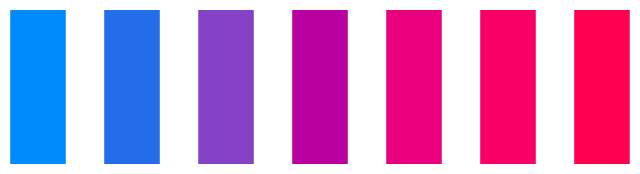

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shap.plots.colors._colors import red_blue

# Define your colormap
# cmap = plt.get_cmap('jet')
cmap = red_blue

# Define vmin and vmax
vmin = 0
vmax = 100

# Define the points where you want to extract the 7 colors
points = [0, 20, 40, 60, 80, 90, 100]

hex_codes = []

# Interpolate colors at specified points
colors_rgb = [cmap((value - vmin) / (vmax - vmin)) for value in points]

print("Extracted hexadecimal colors at specified points:")
for i, color in zip(points, colors_rgb):
    hex_code = mcolors.rgb2hex(color)
    print(f"Value: {i}, Hex Code: {hex_code}")
    hex_codes.append(hex_code)

# Plot to visualize
plt.figure(figsize=(8, 2))
for i, color in enumerate(colors_rgb):
    plt.plot([i, i], [0, 1], color=color, linewidth=40)

plt.axis('off')
plt.show()

In [7]:
from sklearn.cluster import DBSCAN
from umap.umap_ import UMAP
# Identify clusters using DBSCAN
# sv_2d = vvv.cpu().numpy()
# compute 2D embedding of raw variable values
sv_2d = UMAP(
  n_components=2, n_neighbors = 5, min_dist=0.5, metric='correlation'
).fit_transform(vvv.cpu().numpy())

In [8]:
sv_2d_labels = DBSCAN(eps=1, min_samples=3).fit(sv_2d).labels_

for cluster, count in pd.Series(sv_2d_labels).value_counts().sort_index().items():
    print(cluster, count, sv_2d[sv_2d_labels == cluster].mean(0))

y = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors/{pathogen}/labels_test.pt')

# for class colours in scatter plots
c = ["#d45087"] * len(y)  # pink
for i in range(len(y)):
    if y[i] == 1:
        c[i] = "#003f5c"  # blue

filename_prognosis_dict = pd.read_csv('/home/yhchoi/FSTrain_0205/Clinical_FCN_RawVecs/prognosis_labels_all.csv')
filenames = torch.load(f'/home/yhchoi/FSTrain_0205/samplevectors/{pathogen}/filenames_test.pt')
file_ids = [f.split('_')[2] for f in filenames]

file_prognoses = []
for file_id in file_ids:
    prognosis = filename_prognosis_dict[filename_prognosis_dict['ID'] == int(file_id)]['Prognosis'].values[0]
    file_prognoses.append(prognosis)

# for class colours in scatter plots
# list of 7 colors from red to blue
colors = hex_codes
colors_prog = [colors[p] for p in file_prognoses]

0 26 [-1.3181285  9.440954 ]
1 7 [-2.9412925  7.209903 ]
2 34 [9.056334   0.24913609]
3 6 [28.997366 13.544076]
4 3 [1.9330082 9.695894 ]
5 8 [21.052355 15.777154]
6 8 [ 1.0871724 12.073443 ]
7 9 [23.87909   3.349963]
8 4 [ -9.544988  -10.6612015]
9 8 [ 3.7373896 -9.111874 ]


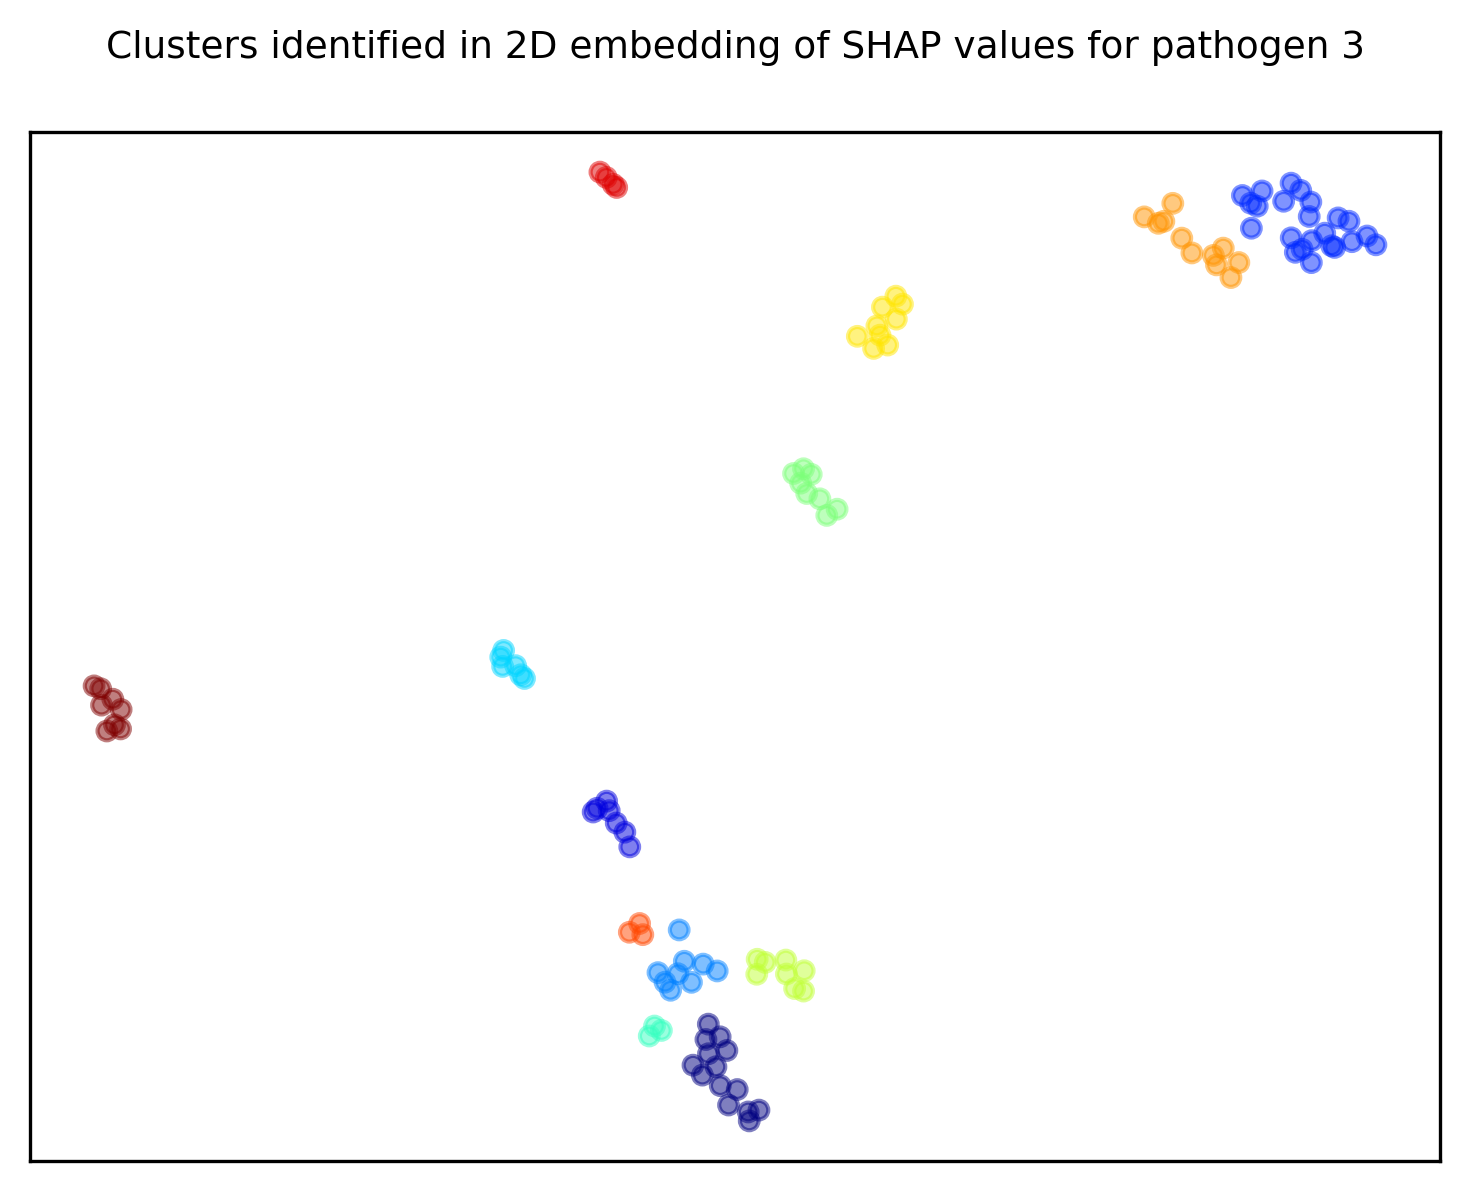

In [71]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
ax.scatter(sv_2d[:, 0], sv_2d[:, 1], c=sv_2d_labels, s=20, alpha=0.5, cmap='jet')
ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

fig.suptitle(
    f"Clusters identified in 2D embedding of SHAP values for pathogen {pathogen}",
    fontsize=9,
)
fig.tight_layout()

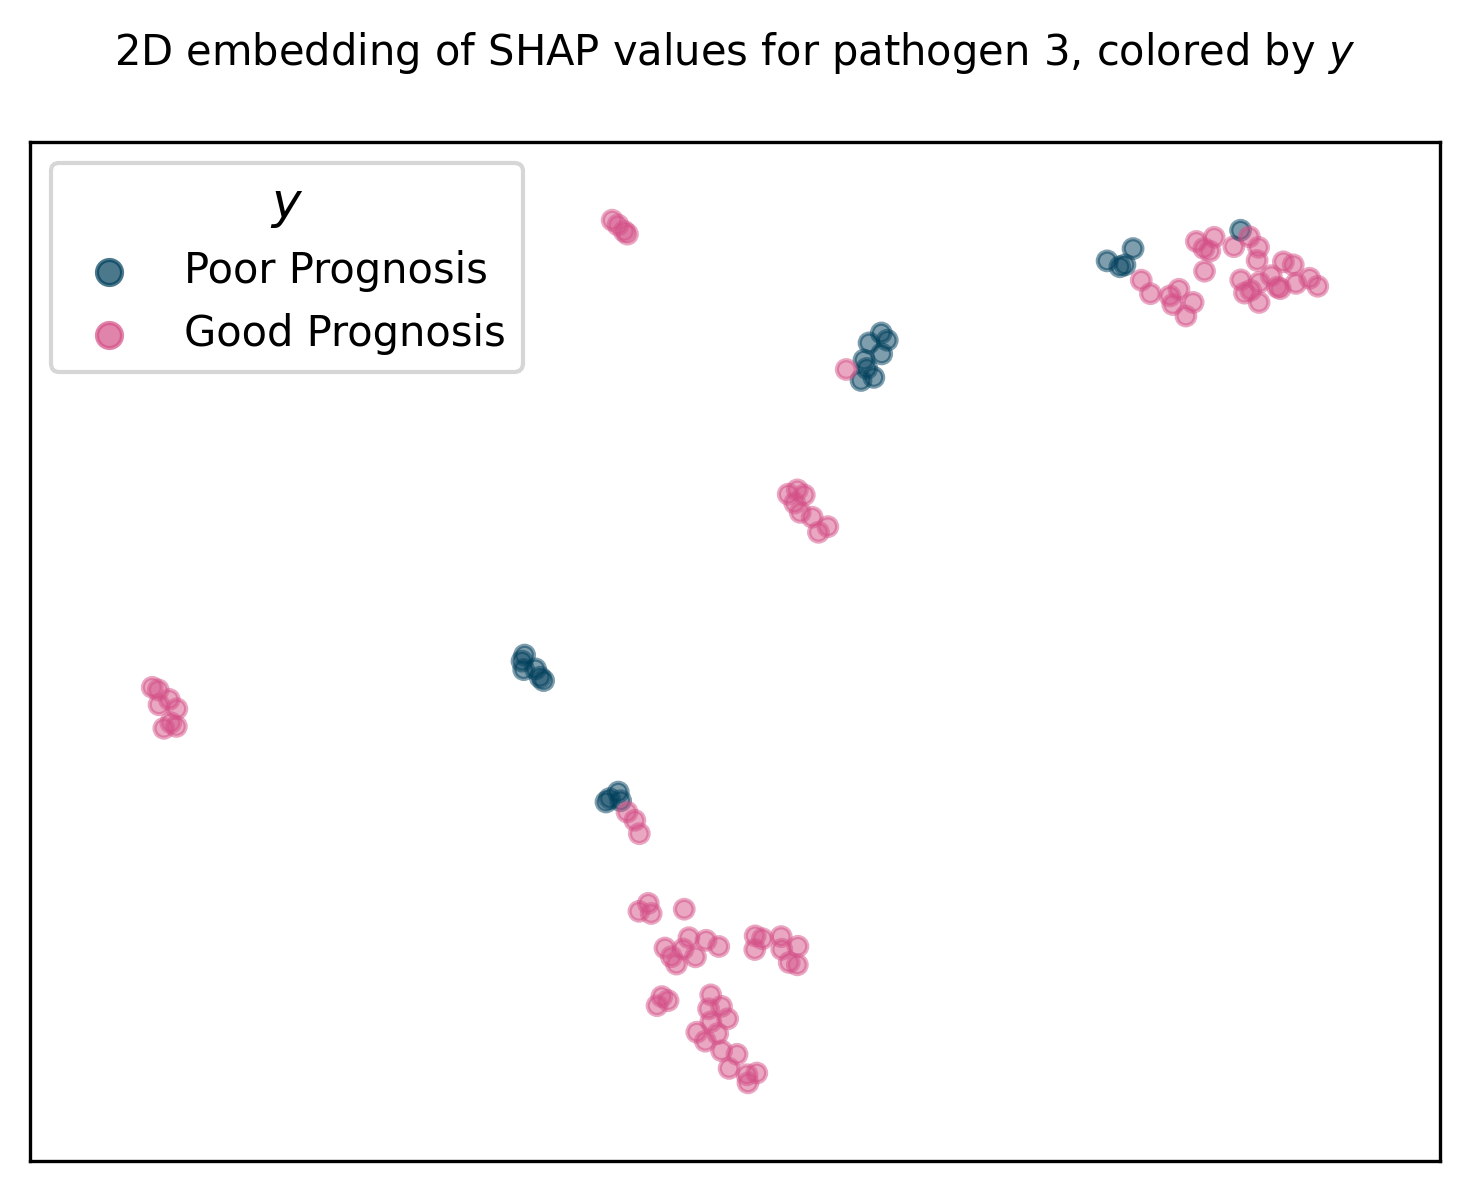

In [72]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
import seaborn as sns
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(sv_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": 0.5, "s": 20, "color": c},
)

# equalise axes and hacky solution for legend
ax.axis("equal")
x, y = ax.get_xlim(), ax.get_ylim()
ax.scatter([99], [99], label="Poor Prognosis", alpha=0.7, color="#003f5c")
ax.scatter([99], [99], label="Good Prognosis", alpha=0.7, color="#d45087")
ax.legend(title="$y$", title_fontsize=12)
ax.set_xlim(x)
ax.set_ylim(y)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

fig.suptitle(
    f"2D embedding of SHAP values for pathogen {pathogen}, colored by $y$",
    fontsize=10,
)
fig.tight_layout()

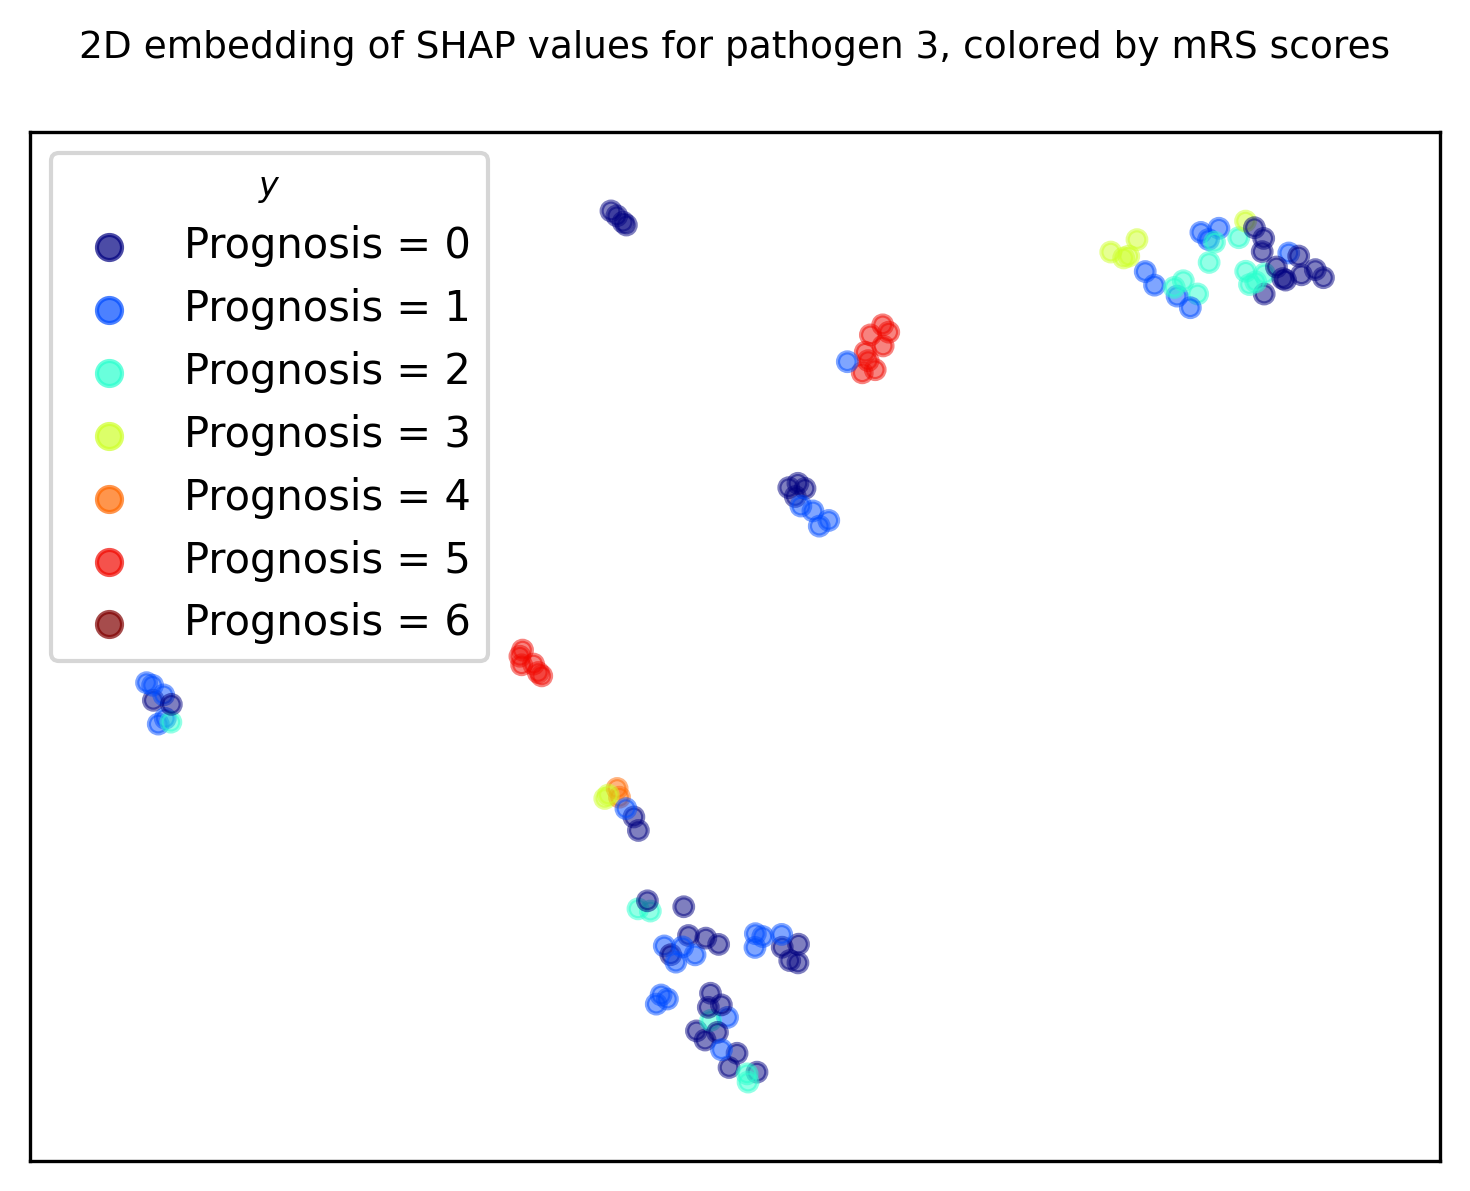

In [74]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
import seaborn as sns
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(sv_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": 0.5, "s": 20, "color": colors_prog},
)

# equalise axes and hacky solution for legend
ax.axis("equal")
x, y = ax.get_xlim(), ax.get_ylim()
for i in range(7):
    ax.scatter([99], [99], label=f"Prognosis = {i}", alpha=0.7, color=colors[i])
ax.legend(title="$y$", title_fontsize=8)
ax.set_xlim(x)
ax.set_ylim(y)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

fig.suptitle(
    f"2D embedding of SHAP values for pathogen {pathogen}, colored by mRS scores",
    fontsize=9,
)
fig.tight_layout()

In [82]:
featurenames

['Cerebellum_White_Matter_left',
 'Cerebellum_White_Matter_right',
 'Cerebellum_Cortex_left',
 'Cerebellum_Cortex_right',
 'Hippocampus_left',
 'Hippocampus_right',
 'parahippocampal_left',
 'parahippocampal_right',
 'entorhinal_left',
 'entorhinal_right',
 'Amygdala_left',
 'Amygdala_right',
 'Thalamus_Proper_left',
 'Thalamus_Proper_right',
 'VentralDC_left',
 'VentralDC_right',
 'Choroid_plexus_left',
 'Choroid_plexus_right',
 'Brain_Stem',
 'cuneus_left',
 'cuneus_right',
 'lateraloccipital_left',
 'lateraloccipital_right',
 'pericalcarine_left',
 'pericalcarine_right',
 'lingual_left',
 'lingual_right',
 'fusiform_left',
 'fusiform_right',
 'inferiortemporal_left',
 'inferiortemporal_right',
 'middletemporal_left',
 'middletemporal_right',
 'superiortemporal_left',
 'superiortemporal_right',
 'transversetemporal_left',
 'transversetemporal_right',
 'insula_left',
 'insula_right',
 'serum_tCO2',
 'Mentality_abnormal',
 'seizure',
 'serum_lactate',
 'urine_albumin_abnormal',
 'serum

In [90]:
featurenames.index('age')

54

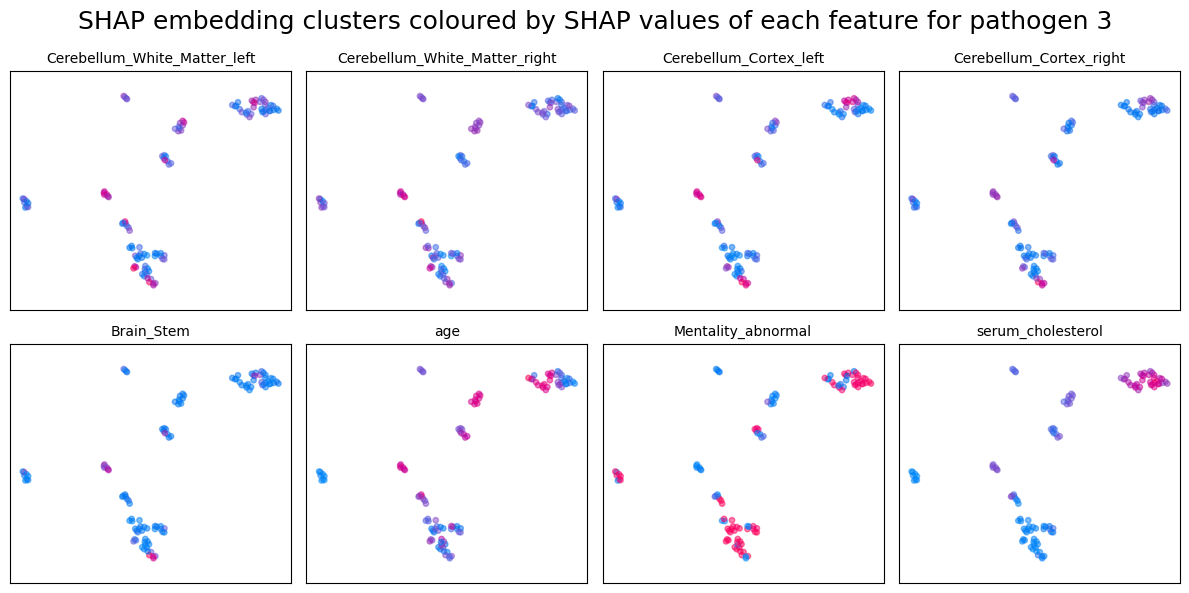

In [92]:
vs = [0, 1, 2, 3, 18, 54, 40, 56]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for ax, v in zip(axes, vs):
    im = ax.scatter(sv_2d[:, 0], sv_2d[:, 1], c=vvv.cpu().numpy()[:, v], s=15, alpha=0.5, cmap=red_blue)
    ax.axis("equal")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{featurenames[v]}", fontsize=10)


fig.suptitle(
    f"SHAP embedding clusters coloured by SHAP values of each feature for pathogen {pathogen}",
    fontsize=18,
)
fig.tight_layout()